# Import Library

Using numpy and pandas

In [84]:
import numpy as np
import pandas as pd
from datetime import datetime
import tensorflow as tf
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from pylab import rcParams
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
import statsmodels.stats.stattools as smtools
from sklearn import linear_model
import seaborn as sns
import scipy.stats as stats
import itertools
from sklearn import preprocessing

# Set matplot size
rcParams['figure.figsize'] = 10, 10
# Date interval option
interval = ['2014-01-01','2015-12-31']
# Corrleation criteria
cor_criteria = 0.5
# VIF step
vif_step = 10

# Read csv file

local의 lab data, rtdv를 읽습니다.
Unnamed로 되어있는 날짜 column은 date로 column 이름 변환합니다.

In [2]:
def read_y_data(csv_file):
    y_df = pd.read_table(csv_file, sep=',')
    y_df.rename(columns={'Unnamed: 0':'date'}, inplace=True)
    return y_df

def read_x_data(csv_file):
    x_df = pd.read_table(csv_file, sep=',')
    x_df.rename(columns={'Unnamed: 0':'date'}, inplace=True)
    return x_df

제한할 날짜 영역과
correlation의 thredshold를 설정하고 데이터를 불러옵니다.

In [4]:
y_df = read_y_data("CDU2_LAB_KERO10.csv");
x_df = read_x_data("CDU2_RTDB.csv");

# Basic eda

1. 설정한 interval로 날짜를 제한합니다.(2012~2014)
2. Unnamed column을 제거합니다.
3. Na column과 row를 제거합니다.
4. constant column을 제거합니다.
5. desciption을 참고하여 column을 제거합니다.
6. reindexing 합니다.

In [5]:
def basic_eda(y_df, x_df, na=True, constant=True, desc=True, named=True, interval= None):
    
    # Use only interval
    if(interval != None):
        x_df = x_df.drop(x_df[(x_df['date'] < interval[0]) | (x_df['date'] > interval[1])].index)
        y_df = y_df.drop(y_df[(y_df['date'] < interval[0]) | (y_df['date'] > interval[1])].index)
    
    # Remove Unnamed tags
    if(named == True):
        x_df = x_df.loc[:, ~x_df.columns.str.contains('^Unnamed')]
        
    # Remove nan rows and columns
    if(na == True):
        x_df = x_df.dropna(axis=1, how='all')
        x_df = x_df.dropna()
        y_df = y_df.dropna()
        
    # Remove constant columns
    if(constant == True):
        x_df = x_df.loc[:,x_df.apply(pd.Series.nunique) != 1]
    
    # Remove columns based on description
    #if(desc == True):
    
    # Reset index
    x_df = x_df.reset_index(drop=True)
    y_df = y_df.reset_index(drop=True)
    
    return x_df, y_df
        
eda_x_df, eda_y_df = basic_eda(y_df=y_df, x_df=x_df, interval=interval)

# Plotting

날짜별 Y data를 plotting 합니다

초록 : 2014~2015

파랑 : 2016~

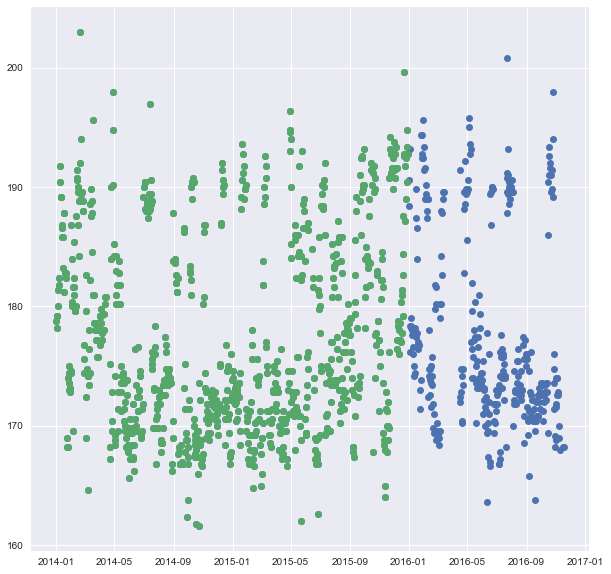

In [6]:
plt.plot_date(y_df['date'],y_df['CDU2KERO10']) #before eda process
plt.plot_date(eda_y_df['date'],eda_y_df['CDU2KERO10']) # after eda process
plt.show()

# Get TA interval

사용자가 지정한 기준 이상의 실험 공백기(TA)를 찾습니다.

TA의 시작일, 마지막일을 제거합니다.(대체로 값이 차이가 남)

TA의 구간을 visualization 합니다.

In [7]:
def difftime(y_df, x_df, criteria, color = None):
    y_len = len(y_df)
    tdelta = np.zeros([y_len -1])
    outlier = []
    FMT = '%Y-%m-%d %H:%M'
    for i in range(y_len-1):
        det = datetime.strptime(y_df['date'][i+1], FMT) - datetime.strptime(y_df['date'][i], FMT)
        tdelta[i] = det.days
        
        #Detect TA range
        if tdelta[i] > criteria:
            outlier.append([y_df['date'][i], y_df['date'][i+1]])
            
    # Show TA range
    x = np.arange(len(tdelta))
    plt.xticks(x, y_df['date'], rotation='vertical')
    plt.plot(x,tdelta, color = color)
    plt.show()
    
    # delete TA ragne from y_df, x_df
    for i in range(0,len(outlier)):
        y_df = y_df.drop(y_df[(y_df['date'] >= outlier[i][0]) & (y_df['date'] <= outlier[i][1])].index)
        x_df = x_df.drop(x_df[(y_df['date'] >= outlier[i][0]) & (x_df['date'] <= outlier[i][1])].index)
        
    
    
    return tdelta, outlier, y_df, x_df

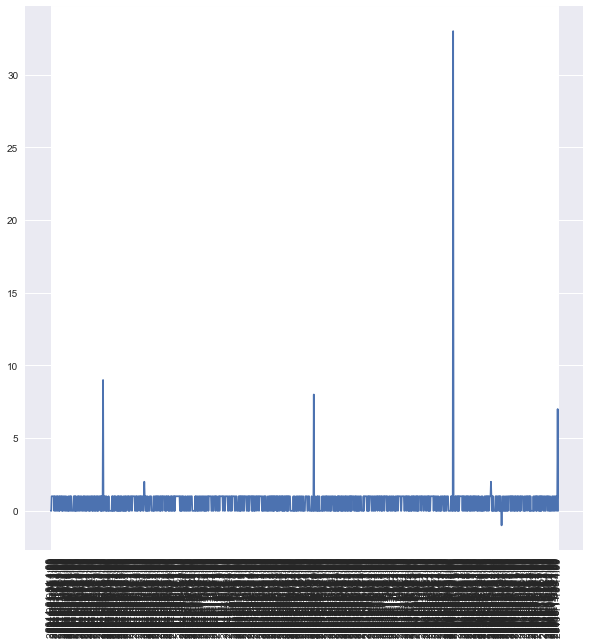

C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:23: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


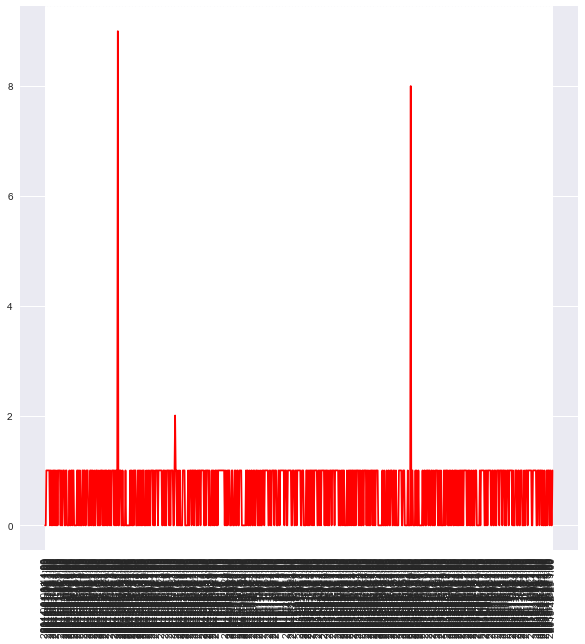



Remove ta's start, end : 
[['2014-04-13 1:00', '2014-04-22 1:00'], ['2015-06-07 1:00', '2015-06-15 8:00']]


In [8]:
difftime(y_df=y_df, x_df=x_df, criteria=7)
tdelta, outlier, ta_y_df, ta_x_df = difftime(y_df=eda_y_df, x_df=eda_x_df, criteria=2, color = 'r')
print("\n\nRemove ta's start, end : ")
print(outlier)

# Merge Lab data and RTDB

key : date

how : inner join

lab data와 RTDB data를 date를 기준으로 합칩니다.

In [9]:
def merge_df(y_df, x_df):
    a = pd.merge(y_df, x_df, on = 'date', how='inner')
    return a

eda_df = merge_df(ta_y_df, ta_x_df)
eda_df

,date,CDU2KERO10,CDU2A901,CDU2A901R,CDU2A902,CDU2A902R,CDU2A903,CDU2A903R,CDU2A904,CDU2A905,...,CDU2YL12A,CDU2YL676,CDU2YP12,CDU2YPC3001,CDU2YPC3001_OP,CDU2YPC3001_SP,CDU2YV3AL,FLU_CDU2,REFCDU2_KG_FL,REFCDU2_NM3_FL
0,2014-01-01 1:00,178.8,1.3191,0.0000,2.5148,0.0000,1.9783,0.0000,3.3407,99.8757,...,46.1206,32.2588,-0.0023,3.5277,0.0,3.7,-1.9265,0.0000,0.0000,0.0000
1,2014-01-01 14:00,178.2,1.5174,0.0000,2.7572,0.0000,2.0414,0.0000,2.7123,104.5310,...,46.0936,40.0522,-0.0033,3.5570,0.0,3.7,-2.1378,0.0000,0.0000,0.0000
2,2014-01-02 1:00,179.2,1.5670,0.0000,2.6821,0.0000,1.9765,0.0000,2.6639,104.0990,...,46.1353,51.2935,-0.0021,3.5115,0.0,3.7,-1.9964,0.0000,0.0000,0.0000
3,2014-01-03 1:00,179.2,1.9795,0.0000,2.6618,0.0000,1.9129,0.0000,4.0385,118.8390,...,46.7285,37.7332,-0.0027,3.5212,0.0,3.7,-1.9129,0.0000,0.0000,0.0000
4,2014-01-04 1:00,180.0,2.1088,0.0000,2.5797,0.0000,1.7851,0.0000,2.3650,120.7090,...,39.1176,30.0615,-0.0026,3.5179,0.0,3.7,-1.9208,0.0000,0.0000,0.0000
5,2014-01-05 1:00,181.4,2.2394,0.0000,2.8063,0.0000,2.3803,0.0000,2.3197,129.0800,...,39.6732,49.3791,-0.0031,3.5123,0.0,3.7,-1.7882,0.0000,0.0000,0.0000
6,2014-01-06 1:00,182.4,2.1645,0.0000,2.7811,0.0000,2.3677,0.0000,1.9871,131.3470,...,40.3156,30.8391,-0.0030,3.5266,0.0,3.7,-1.7744,0.0000,0.0000,0.0000
7,2014-02-06 1:00,181.0,2.8727,1.8305,2.4397,1.6848,2.3975,2.7015,2.3682,125.6250,...,41.1627,38.0904,-0.0025,3.6669,0.0,3.7,-1.6924,0.0000,0.0000,0.0000
8,2014-02-07 1:00,182.4,2.6026,1.3696,2.2944,1.5348,2.0053,2.5890,2.4242,116.6970,...,42.5596,24.5004,-0.0030,3.6956,0.0,3.7,-1.8553,0.0000,0.0000,0.0000
9,2014-02-08 18:00,179.6,2.8150,1.4977,2.3312,1.5829,2.0813,2.7351,3.5270,126.5470,...,44.8153,40.1989,-0.0035,3.6768,0.0,3.7,-1.9736,0.0000,0.0000,0.0000


# basic eda와 correlation 기준치 필터링

basic eda를 거친 후 사용자가 지정한 correlation 기준치 이하의 column들을 선택합니다.

In [54]:
def cal_out_cor(df, criteria, outlier=False):
    tags = np.array(df.columns.values)
    correlation = np.array(df['CDU2KERO10'])
    #print(correlation)
    
    # Select columns names over criteria
    if outlier==False:
        tags = tags[np.where( abs(correlation) >= criteria)]
    
    else:
        outliers = abs(correlation - np.mean(correlation)) > 3 * np.std(correlation)
        print(outliers)
        tags = tags[outliers]
        
    # Remove y tag
    tags = np.delete(tags, np.argwhere(tags=='CDU2KERO10'))
    #print(tags)
    
    return tags

# Get tag list(> correlation criteria)

sel_cor = cal_out_cor(eda_df.corr(), cor_criteria, outlier=False)
print(sel_cor)
print(len(sel_cor))

['CDU2F572' 'CDU2FC571' 'CDU2FC571_SP' 'CDU2FC585' 'CDU2FC585_1000'
 'CDU2FC585_OP' 'CDU2FC585_SP' 'CDU2FC592B' 'CDU2FC592B_SP' 'CDU2FY572'
 'CDU2FY572R' 'CDU2LC581_OP' 'CDU2LC582_OP' 'CDU2LIC631_OP' 'CDU2RA585'
 'CDU2T535' 'CDU2T536' 'CDU2T542' 'CDU2T571' 'CDU2T758' 'CDU2T931'
 'CDU2T934' 'CDU2T948' 'CDU2T949' 'CDU2T957' 'CDU2T983' 'CDU2T986'
 'CDU2T987' 'CDU2T988' 'CDU2T989' 'CDU2T990']
31


C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater_equal
  


# Vaiable selection - VIF Test, Correlation

de_max_vif :

VIF Test를 한 단계씩 거치며

VIF의 Max column을 단계별로 제거합니다.

2번째 인자를 통해 단계를 정할 수 있습니다.



get_summary :

test data와 training data를 나눕니다.(2:1)

statsmodel의 linearmodel을 이용하여 선형 회귀 모델을 생성합니다.

model의 summary를 출력합니다.

In [63]:
# One solution to dealing with multicollinearity is to remove some of the violating predictors from the model.
def de_max_vif(df, loop=5):
    vif = pd.DataFrame()
    df = df.loc[:, ~df.columns.str.contains('CDU2KERO10')]
    df = df.loc[:, (df != df.ix[0]).any()] 
    
    vif["VIF Factor"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    vif["features"] = df.columns
    vif.round(1)
    sorted_vif = vif.sort_values(['VIF Factor'], ascending=[False])
    sort_vif_tag = np.array(sorted_vif['features'])
    max_ = sort_vif_tag[0]
    

    for i in range(0,loop):
        vif = pd.DataFrame()
        df = df.loc[:, ~df.columns.str.contains(max_)]
        vif["VIF Factor"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
        vif["features"] = df.columns
        vif.round(1)
        
        sorted_vif = vif.sort_values(['VIF Factor'], ascending=[False])
        sort_vif_tag = np.array(sorted_vif['features'])
        max_ = sort_vif_tag[0]
        
        print(vif)
        print("\nvif\n"+max_+"\n\n")
        
    return vif

def variable_select(df, sel_cor, option=False):
    
    sel_df = df[np.append((sel_cor),["CDU2KERO10"])]
    vif_eda = sel_df.loc[:, ~sel_df.columns.str.contains('date')]
    
    # For each X, calculate VIF and save in dataframe
    vif = de_max_vif(vif_eda, vif_step)
    
    # Remove vif features
    if option == False:
        vif_eda = vif_eda[np.append(np.array(vif.features),["CDU2KERO10"])]
    if option == True:
        vif_eda.drop(np.array(vif.features), axis=1, inplace=True)
    print("\n\n")
    
    vif_eda = vif_eda.loc[:, (vif_eda != vif_eda.ix[0]).any()] 
    return vif_eda

def get_summary(df, y_label):
    y = df.loc[:, df.columns.str.contains(y_label)]
    X = df.loc[:, ~df.columns.str.contains(y_label)]
    
    train_num = (int(len(y)/3*2))
    
    X = sm.add_constant(X)
    train_y = y[:train_num]
    train_X = X[:train_num]
    test_y = y[train_num:]
    test_X = X[train_num:]
    
    #print("train_y")
    #print(len(train_y))
    #print("train_X")
    #print(len(test_y))
    
    #train_X = sm.add_constant(train_X)
    model = sm.OLS(train_y, train_X).fit()
    print(model.summary())
        
    return model, test_y, test_X

In [50]:
eda_df
sel_cor

array(['CDU2F572', 'CDU2FC571', 'CDU2FC571_SP', 'CDU2FC585',
       'CDU2FC585_1000', 'CDU2FC585_OP', 'CDU2FC585_SP', 'CDU2FC592B',
       'CDU2FC592B_SP', 'CDU2FY572', 'CDU2FY572R', 'CDU2LC581_OP',
       'CDU2LC582_OP', 'CDU2LIC631_OP', 'CDU2RA585', 'CDU2T535',
       'CDU2T536', 'CDU2T542', 'CDU2T571', 'CDU2T758', 'CDU2T931',
       'CDU2T934', 'CDU2T948', 'CDU2T949', 'CDU2T957', 'CDU2T983',
       'CDU2T986', 'CDU2T987', 'CDU2T988', 'CDU2T989', 'CDU2T990'], dtype=object)

# Prediction - OLS linear model

y와 x1, x2.. 변수의 plot

실제 data와 예측 data의 RMSE 값

summary 를 출력합니다.

X 변수간 plotting 하여, 모든 변순간 상관성을 파악하고 이를 바탕으로 변수 선택을 합니다.

C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  """


       VIF Factor        features
0     3362.285413        CDU2F572
1     2906.906610       CDU2FC571
2    41183.396847       CDU2FC585
3       69.992445  CDU2FC585_1000
4       21.079057    CDU2FC585_OP
5    41024.357528    CDU2FC585_SP
6    33196.016528      CDU2FC592B
7    32038.782407   CDU2FC592B_SP
8    15921.408423       CDU2FY572
9    15524.603788      CDU2FY572R
10      68.763641    CDU2LC581_OP
11     438.158805    CDU2LC582_OP
12    1977.057566   CDU2LIC631_OP
13      72.370569       CDU2RA585
14  134033.495726        CDU2T535
15   53318.240226        CDU2T536
16  157257.560814        CDU2T542
17    2339.156855        CDU2T571
18     690.204830        CDU2T758
19   17434.301480        CDU2T931
20    6865.329329        CDU2T934
21    1798.726085        CDU2T948
22    6847.867937        CDU2T949
23    6661.199193        CDU2T957
24    7725.916761        CDU2T983
25    2231.657203        CDU2T986
26    1344.518727        CDU2T987
27    6864.949675        CDU2T988
28     951.802

C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:44: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix


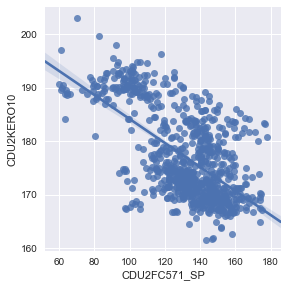

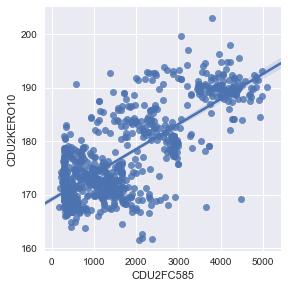

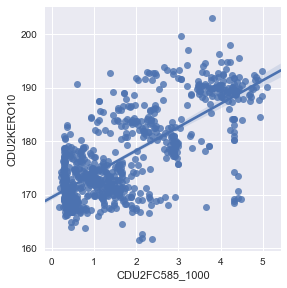

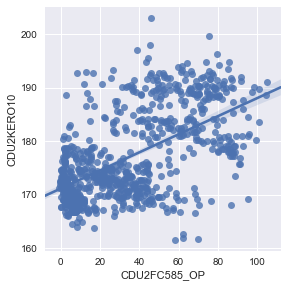

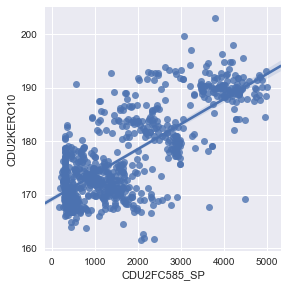

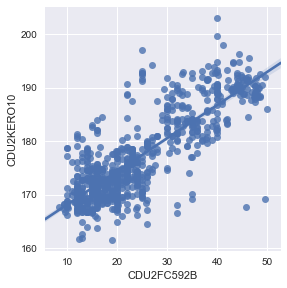

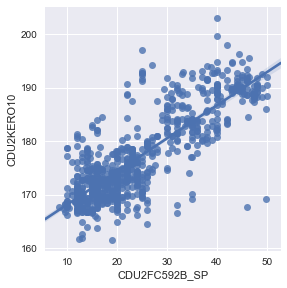

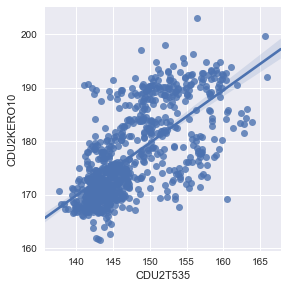

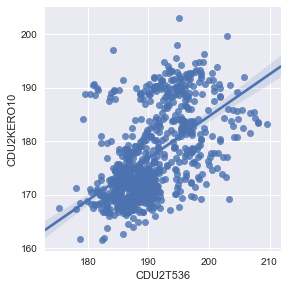

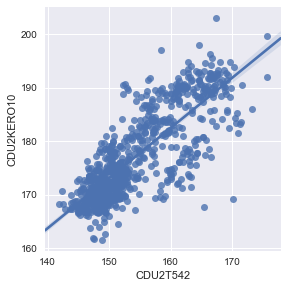

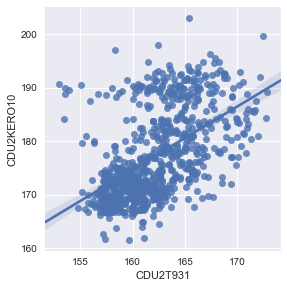

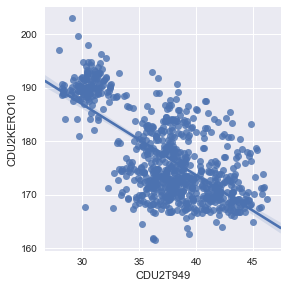

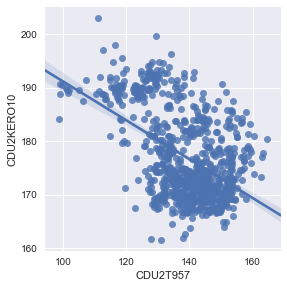

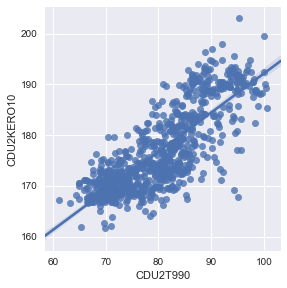

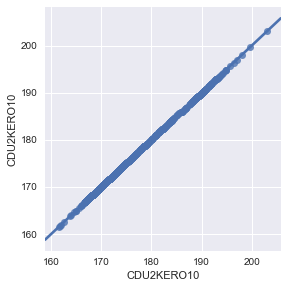

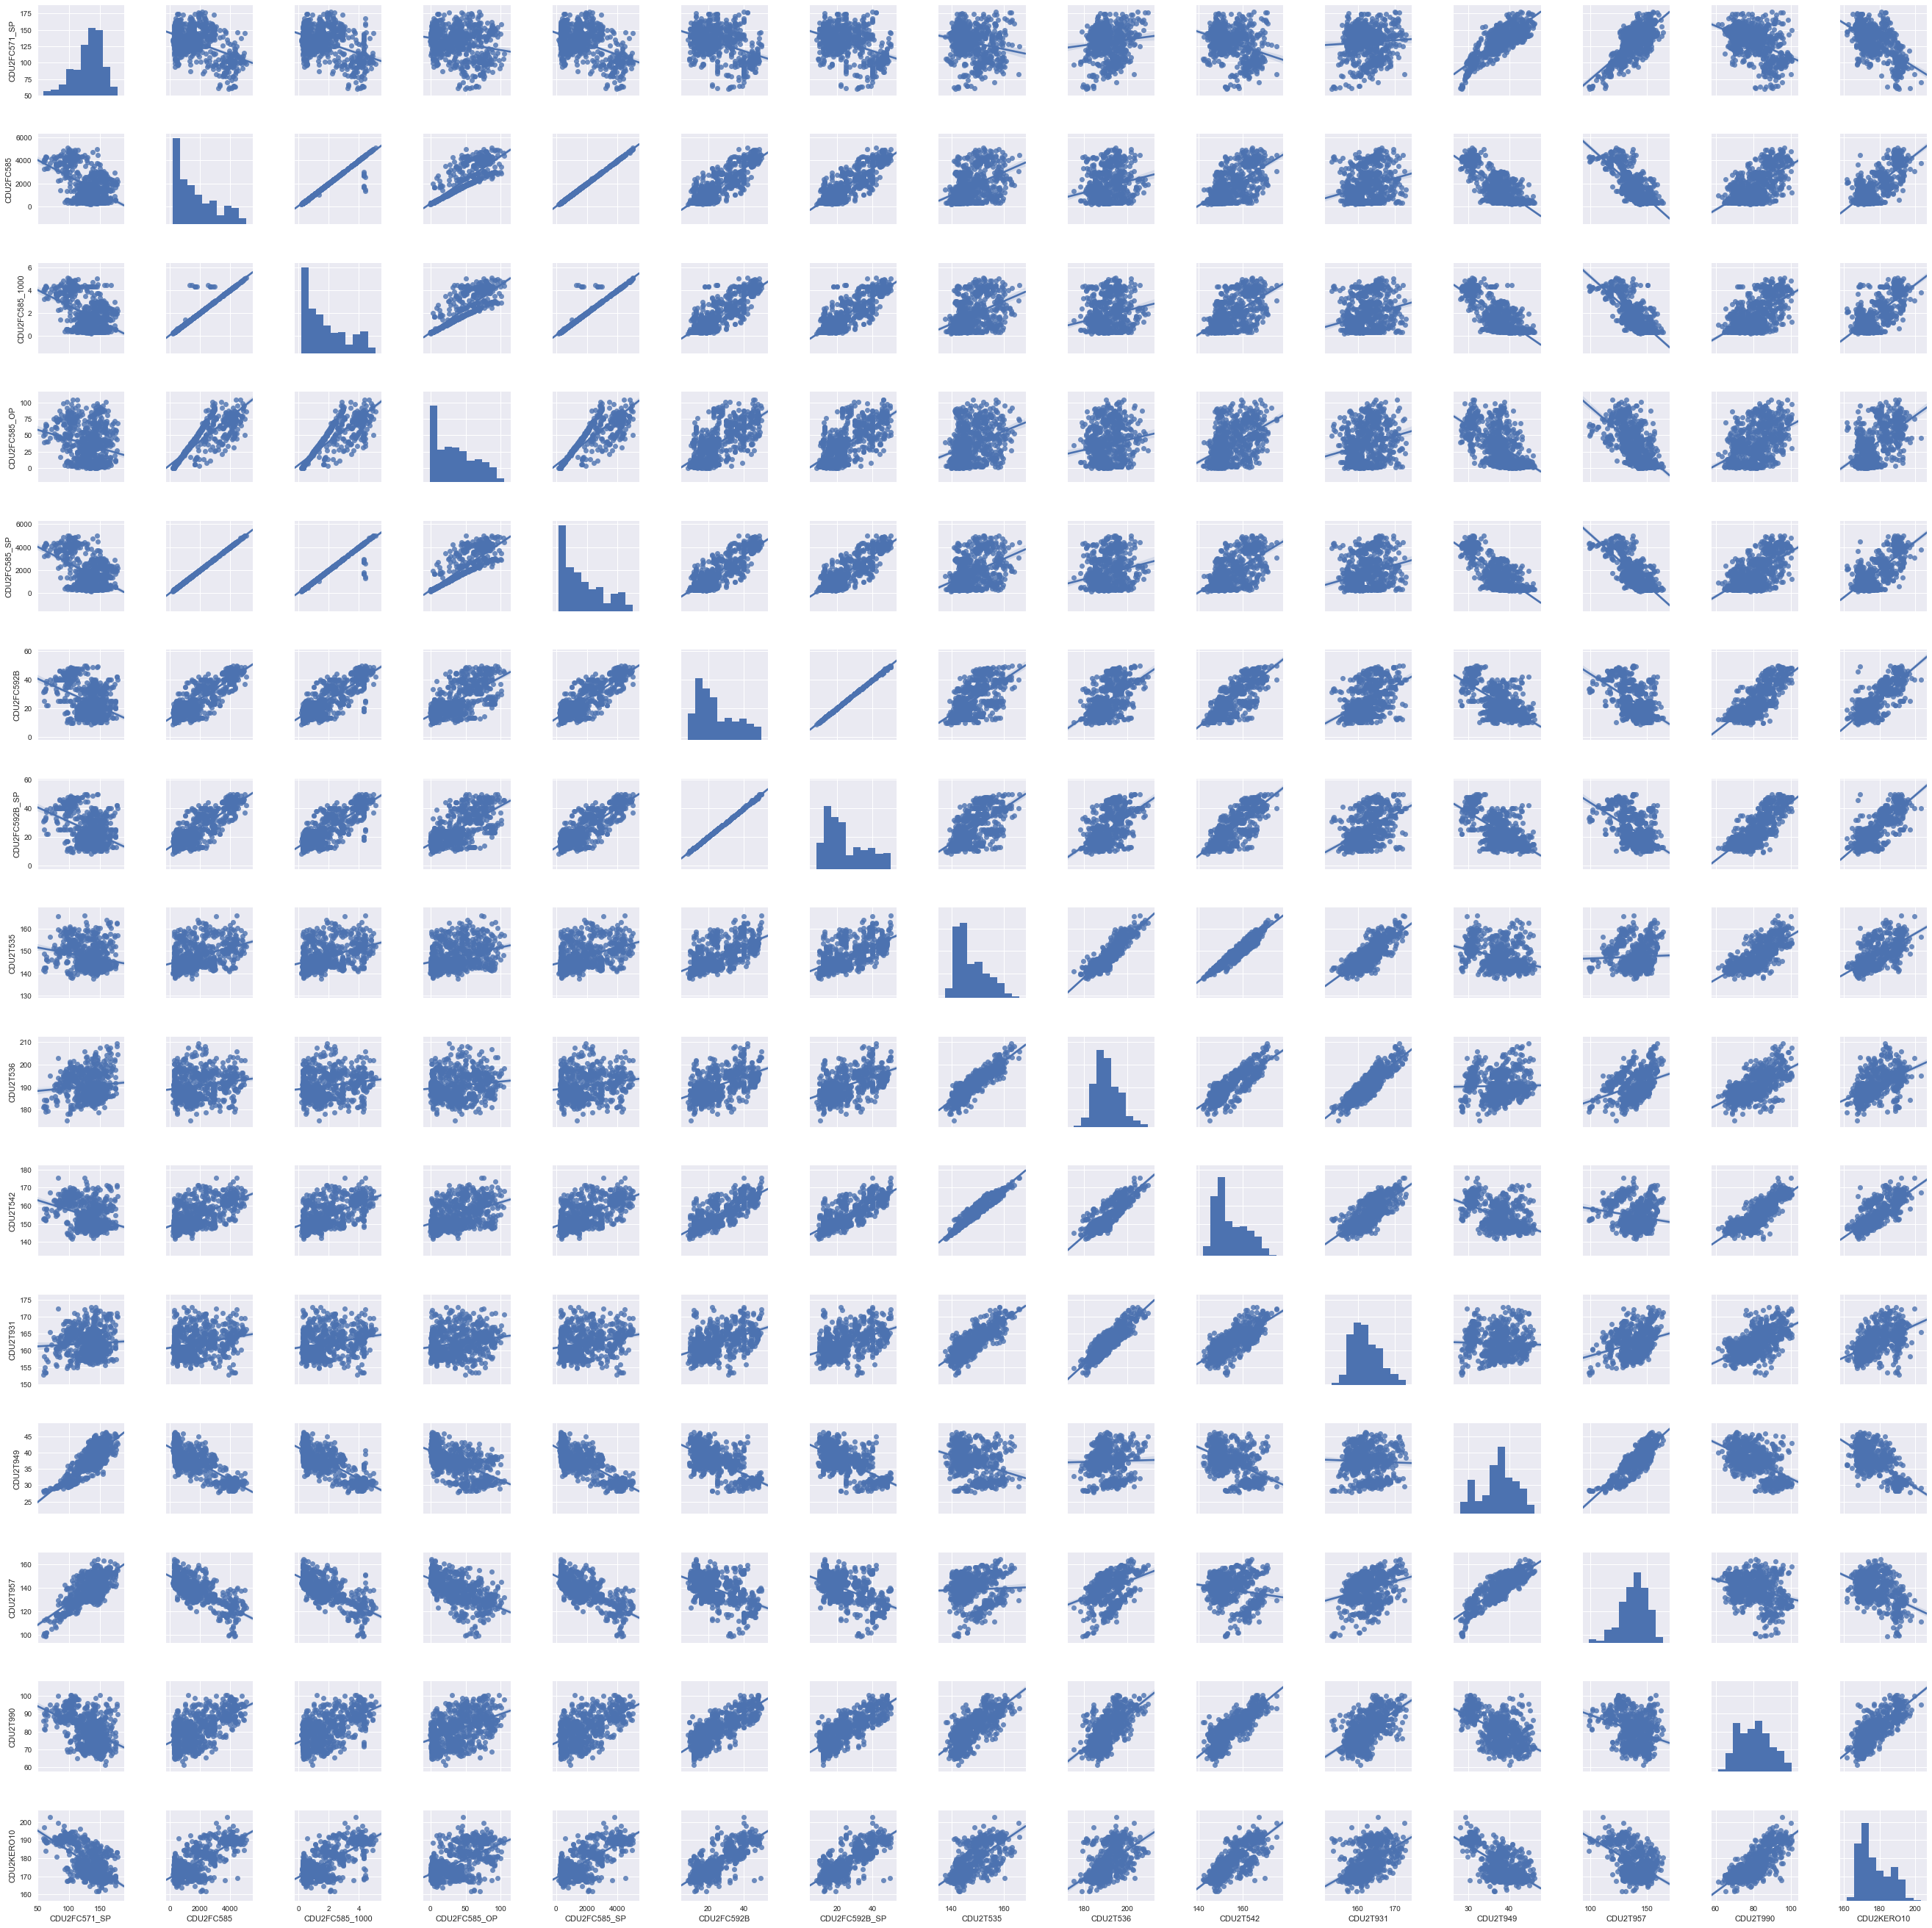

                            OLS Regression Results                            
Dep. Variable:             CDU2KERO10   R-squared:                       0.942
Model:                            OLS   Adj. R-squared:                  0.940
Method:                 Least Squares   F-statistic:                     589.9
Date:                Tue, 11 Jul 2017   Prob (F-statistic):          7.10e-304
Time:                        14:50:40   Log-Likelihood:                -1082.2
No. Observations:                 524   AIC:                             2194.
Df Residuals:                     509   BIC:                             2258.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -3.2918      9.394     -0.

In [58]:
# Variable selection
final_df = variable_select(eda_df, sel_cor, True)

# Plotting graph
for tag in final_df.columns.values:
    sns.lmplot(x=tag,y='CDU2KERO10',data=final_df,fit_reg=True)      
plt.show()    

sns.pairplot(final_df, vars=np.array(final_df.columns.values), kind='reg') 
sns.plt.show()  
# Get summary of selected variables
model, test_y, test_X = get_summary(final_df, 'CDU2KERO10')
y_ = np.array(test_y).transpose()[0]
y = np.array(model.predict(test_X))

# Calculate RSS
print(y_)
print(y)
print("\n\nRmsE:")
print(np.sqrt(((y_ - y) **2).mean()))

In [69]:
train_data = final_df[:(int(len(final_df)/3*2))]
test_data = final_df[(int(len(final_df)/3*2)):]
#print(final_df.columns.values)

['CDU2FC571_SP' 'CDU2FC585' 'CDU2FC585_1000' 'CDU2FC585_OP' 'CDU2FC585_SP'
 'CDU2FC592B' 'CDU2FC592B_SP' 'CDU2T535' 'CDU2T536' 'CDU2T542' 'CDU2T931'
 'CDU2T949' 'CDU2T957' 'CDU2T990']


C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\matplotlib\cbook.py:136: MatplotlibDeprecationWarning: The set_color_cycle attribute was deprecated in version 1.5. Use set_prop_cycle instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


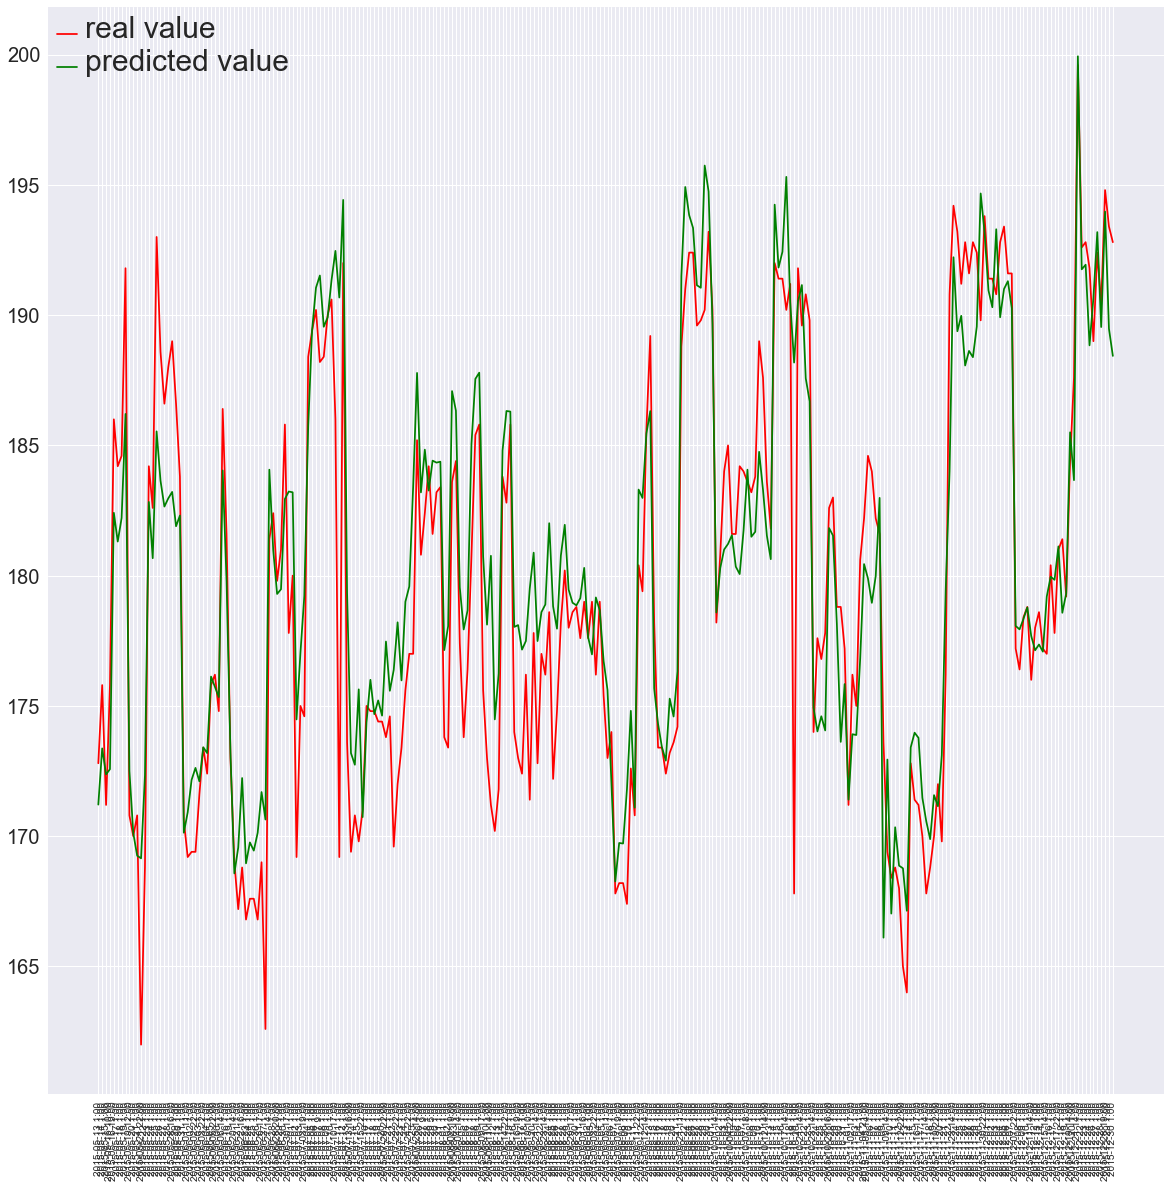

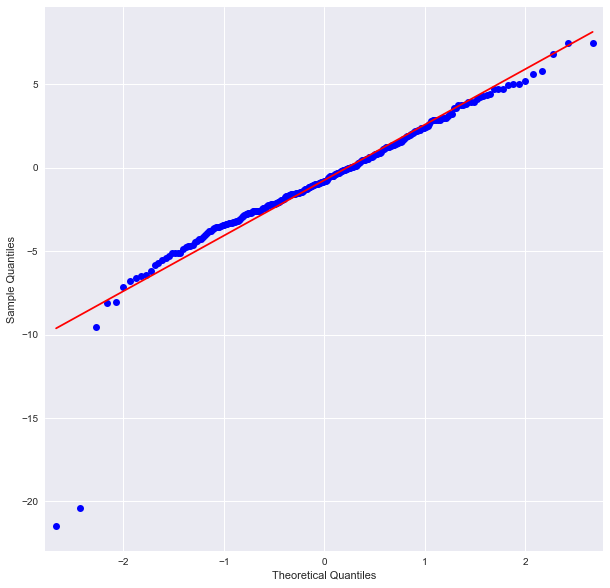



 durbin watsion test :


1.1523992778849181

In [104]:
rcParams['figure.figsize'] = 20, 20
rcParams['font.size'] = 40
train_num = int(len(eda_df)/3*2)
train_interval = np.array(eda_df.date[train_num:])

real_value = np.append(train_interval, y_).reshape((2, len(y_)))
predict_value = np.append(train_interval, y).reshape((2, len(y)))

x = np.arange(len(real_value[0]))
plt.xticks(x, real_value[0], rotation='vertical')
plt.yticks(  fontsize = 20)
#plt.plot(x,real_value[1], color = 'r')

plt.gca().set_color_cycle(['red', 'green'])
plt.plot(x,real_value[1])
plt.plot(x,predict_value[1])
legend = plt.legend(['real value', 'predicted value'])
legend.get_title().set_fontsize('10') #legend 'Title' fontsize
plt.setp(plt.gca().get_legend().get_texts(), fontsize='30') #legend 'list' fontsize

plt.show()

rcParams['figure.figsize'] = 10, 10
sm.qqplot(y_ - y, line="r")
plt.show()

print("\n\n durbin watsion test :")
smtools.durbin_watson(y_ -y, axis=0)

# DNNRegressor - tensorflow

hidden unit : [128, 64, 32]

optimizer : Adagrad optimizer
 - 변수들을 update할 때 각각의 변수마다 step size를 다르게 설정해서 이동
 
activation_fn : relu

normalization - 예측력 낮음


C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  """


       VIF Factor        features
0     3362.285413        CDU2F572
1     2906.906610       CDU2FC571
2    41183.396847       CDU2FC585
3       69.992445  CDU2FC585_1000
4       21.079057    CDU2FC585_OP
5    41024.357528    CDU2FC585_SP
6    33196.016528      CDU2FC592B
7    32038.782407   CDU2FC592B_SP
8    15921.408423       CDU2FY572
9    15524.603788      CDU2FY572R
10      68.763641    CDU2LC581_OP
11     438.158805    CDU2LC582_OP
12    1977.057566   CDU2LIC631_OP
13      72.370569       CDU2RA585
14  134033.495726        CDU2T535
15   53318.240226        CDU2T536
16  157257.560814        CDU2T542
17    2339.156855        CDU2T571
18     690.204830        CDU2T758
19   17434.301480        CDU2T931
20    6865.329329        CDU2T934
21    1798.726085        CDU2T948
22    6847.867937        CDU2T949
23    6661.199193        CDU2T957
24    7725.916761        CDU2T983
25    2231.657203        CDU2T986
26    1344.518727        CDU2T987
27    6864.949675        CDU2T988
28     951.802

C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:46: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix


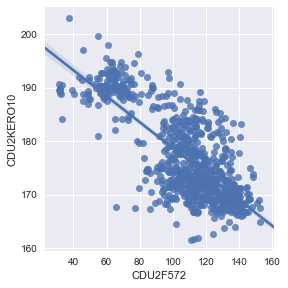

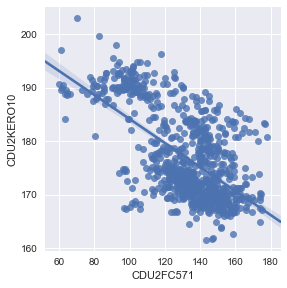

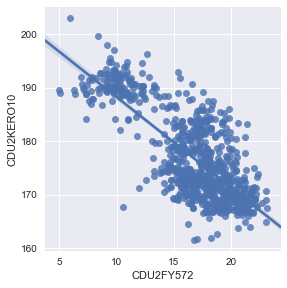

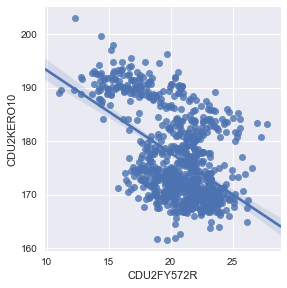

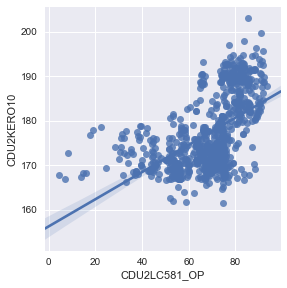

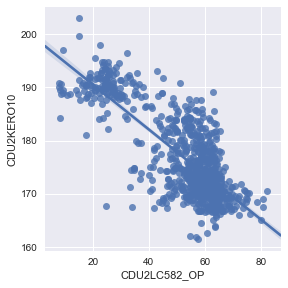

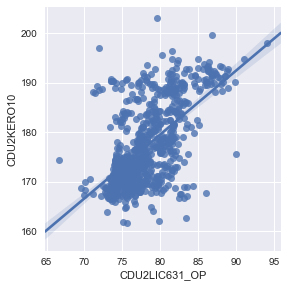

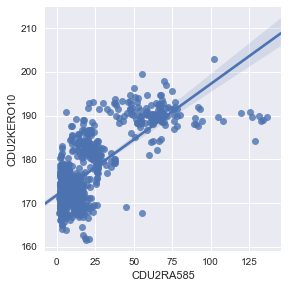

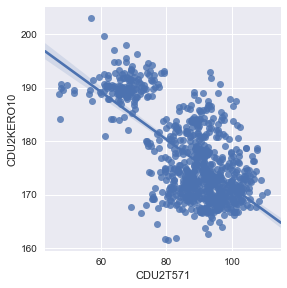

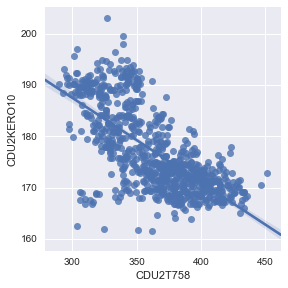

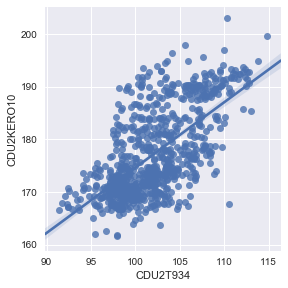

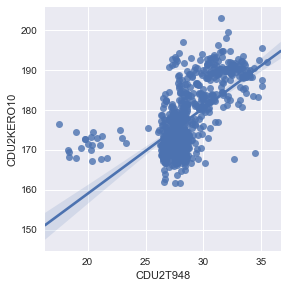

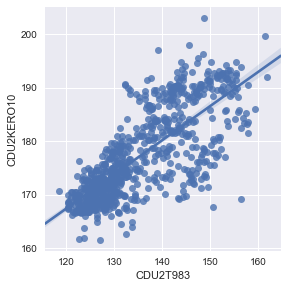

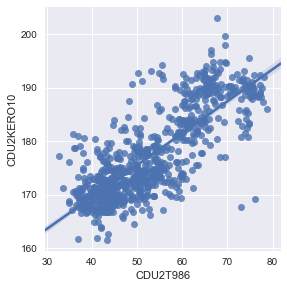

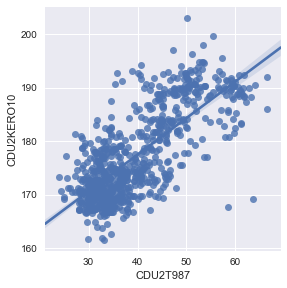

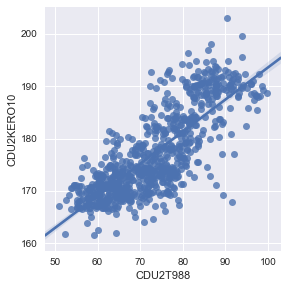

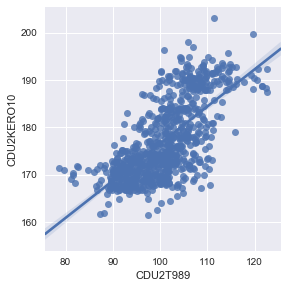

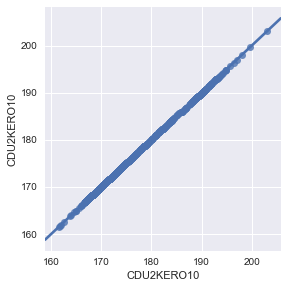

'\n# 표준화 - 좋지 않음\nfinal_df2 = (final_df2 - final_df2.mean()) / (final_df2.max() - final_df2.min())\nfinal_df2["CDU2KERO10"] = y_label\n'

In [100]:
# Variable selection
#eda_df.corr()
final_df2 = variable_select(eda_df, sel_cor, False)
y_label = final_df2["CDU2KERO10"]

mean_ = final_df2["CDU2KERO10"].mean()
max_ = final_df2["CDU2KERO10"].max()
min_ = final_df2["CDU2KERO10"].min()


for tag in final_df2.columns.values:
    sns.lmplot(x=tag,y='CDU2KERO10',data=final_df2,fit_reg=True)      
plt.show() 

'''
# 표준화 - 좋지 않음
final_df2 = (final_df2 - final_df2.mean()) / (final_df2.max() - final_df2.min())
final_df2["CDU2KERO10"] = y_label
'''

# Plotting graph
#for tag in final_df2.columns.values:
#    sns.lmplot(x=tag,y='CDU2KERO10',data=final_df2,fit_reg=True)      
#plt.show()

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_keep_checkpoint_max': 5, '_save_summary_steps': 100, '_num_worker_replicas': 0, '_master': '', '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, '_task_type': None, '_num_ps_replicas': 0, '_evaluation_master': '', '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x0000000045267400>, '_environment': 'local', '_tf_random_seed': None, '_is_chief': True, '_model_dir': None, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_keep_checkpoint_every_n_hours': 10000}
Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list of tags to a scalar summary op is no longer supported.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow

INFO:tensorflow:step = 3401, loss = 7.00013 (0.320 sec)
INFO:tensorflow:global_step/sec: 292.397
INFO:tensorflow:step = 3501, loss = 6.80991 (0.358 sec)
INFO:tensorflow:global_step/sec: 291.885
INFO:tensorflow:step = 3601, loss = 6.82314 (0.327 sec)
INFO:tensorflow:global_step/sec: 285.632
INFO:tensorflow:step = 3701, loss = 6.90295 (0.350 sec)
INFO:tensorflow:global_step/sec: 300.841
INFO:tensorflow:step = 3801, loss = 6.525 (0.332 sec)
INFO:tensorflow:global_step/sec: 301.204
INFO:tensorflow:step = 3901, loss = 6.47287 (0.332 sec)
INFO:tensorflow:global_step/sec: 296.735
INFO:tensorflow:step = 4001, loss = 6.35865 (0.353 sec)
INFO:tensorflow:global_step/sec: 298.953
INFO:tensorflow:step = 4101, loss = 6.35878 (0.335 sec)
INFO:tensorflow:global_step/sec: 301.204
INFO:tensorflow:step = 4201, loss = 6.22225 (0.332 sec)
INFO:tensorflow:global_step/sec: 262.26
INFO:tensorflow:step = 4301, loss = 6.2238 (0.366 sec)
INFO:tensorflow:global_step/sec: 269.759
INFO:tensorflow:step = 4401, loss 

Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list of tags to a scalar summary op is no longer supported.
INFO:tensorflow:Starting evaluation at 2017-07-11-07:44:17
INFO:tensorflow:Restoring parameters from C:\Users\ADMINI~1\AppData\Local\Temp\tmpu_9r_4wh\model.ckpt-10000
INFO:tensorflow:Evaluation [1/1]
INFO:tensorflow:Finished evaluation at 2017-07-11-07:44:18
INFO:tensorflow:Saving dict for global step 10000: global_step = 10000, loss = 59.2018
Loss: 59.201824
Instructions for updating:
Please switch to predict_scores, or set `outputs` argument.
INFO:tensorflow:Restoring parameters from C:\Users\ADMINI~1\AppData\Local\Temp\tmpu_9r_4wh\model.ckpt-10000
Predictions: [170.78133, 175.11266, 173.15244, 172.99287, 185.40306, 183.76924, 184.19325, 186.07993, 170.96985, 1

C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\matplotlib\cbook.py:136: MatplotlibDeprecationWarning: The set_color_cycle attribute was deprecated in version 1.5. Use set_prop_cycle instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


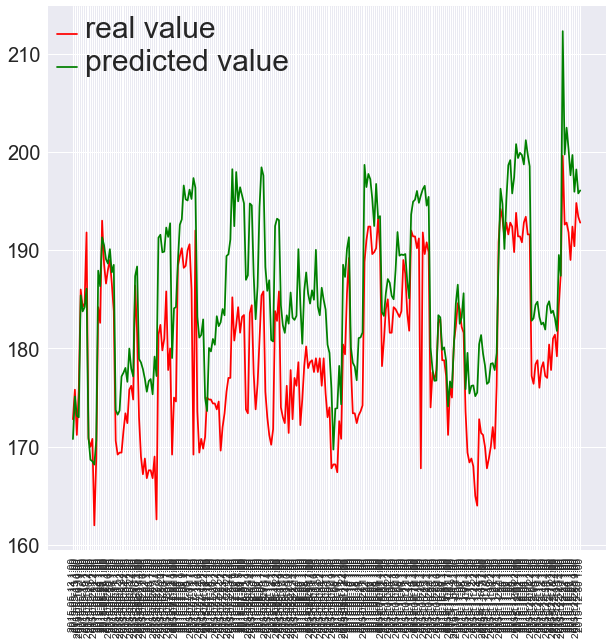

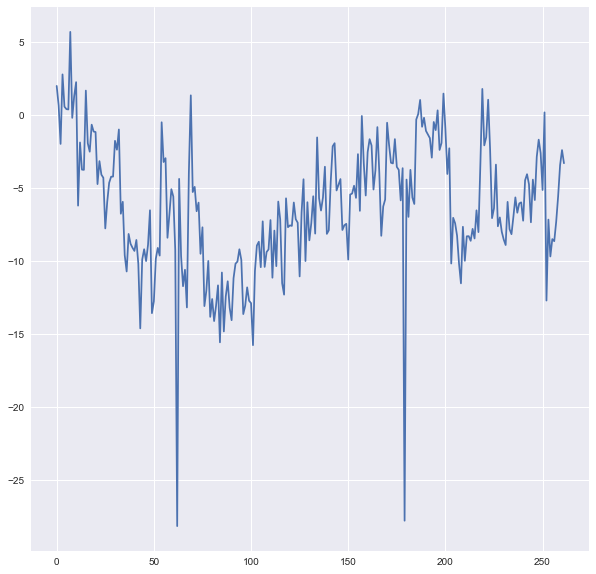



RMSE:
7.694272586


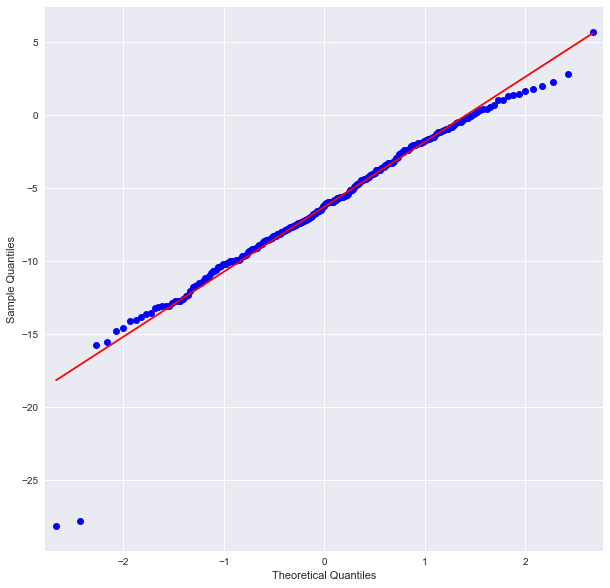



 durbin watson test :
0.277437443499


SystemExit: 

C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py:2870: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [106]:
import pandas as pd
import tensorflow as tf

#tf.logging.set_verbosity(tf.logging.INFO)

COLUMNS = final_df2.columns.values
FEATURES =  np.delete(final_df2.columns.values, np.argwhere(final_df2.columns.values=='CDU2KERO10'))
LABEL = "CDU2KERO10"

train_data = final_df2[:(int(len(final_df2)/3*2))]
test_data = final_df2[(int(len(final_df2)/3*2)):]
predict_set = test_data.loc[:, ~test_data.columns.str.contains('CDU2KERO10')]


def input_fn(data_set):
    feature_cols = {k: tf.constant(data_set[k].values) for k in FEATURES}
    labels = tf.constant(data_set[LABEL].values)
    return feature_cols, labels


def main(unused_argv):
    # Load datasets
    training_set = train_data
    test_set = test_data
    '''
    # Set of 6 examples for which to predict median house values
    prediction_set = pd.read_csv("boston_predict.csv", skipinitialspace=True,
                                 skiprows=1, names=COLUMNS)
    '''
    # Feature cols
    feature_cols = [tf.contrib.layers.real_valued_column(k) for k in FEATURES]

    # Build 2 layer fully connected DNN with 10, 10 units respectively.
    regressor = tf.contrib.learn.DNNRegressor(
    feature_columns=feature_cols, hidden_units=[128, 64, 32])
    #optimizer = tf.train.AdamOptimizer

    # Fit
    regressor.fit(input_fn=lambda: input_fn(training_set), steps=10000)

    # Score accuracy
    ev = regressor.evaluate(input_fn=lambda: input_fn(test_set), steps=1)
    loss_score = ev["loss"]
    print("Loss: {0:f}".format(loss_score))
    
    # Print out predictions    
    y = regressor.predict(input_fn=lambda: input_fn(test_set))
    predictions = list(itertools.islice(y, len(test_data)))
    print("Predictions: {}".format(str(predictions)))
    print("\n\n")
    print(predictions)
    
    
    x = np.arange(len(y_))
    plt.xticks(x, real_value[0], rotation='vertical')
    plt.yticks(  fontsize = 20)
    #plt.plot(x,real_value[1], color = 'r')

    plt.gca().set_color_cycle(['red', 'green'])
    plt.plot(x,y_)
    plt.plot(x,predictions)
    legend = plt.legend(['real value', 'predicted value'])
    legend.get_title().set_fontsize('10') #legend 'Title' fontsize
    plt.setp(plt.gca().get_legend().get_texts(), fontsize='30') #legend 'list' fontsize
    plt.show()
    plt.plot(y_ - predictions)
    plt.show()
    
    print("\n\nRMSE:")
    print(np.sqrt(((y_ - predictions) **2).mean()))
    
    rcParams['figure.figsize'] = 10, 10
    sm.qqplot(y_ - predictions, line='r')
    plt.show()

    
    print("\n\n durbin watson test :")
    print(smtools.durbin_watson(y_ -predictions, axis=0))
    
if __name__ == "__main__":
    tf.app.run()


In [92]:
train_data = final_df[:(int(len(final_df)/3*2))]
test_data = final_df[(int(len(final_df)/3*2)):]
print(len(test_data))

262
